<a href="https://colab.research.google.com/github/davetew/Zero-Carbon-Aviation/blob/master/Propulsion_System_Specific_Energy_Contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aircraft Payload and Range Performance
This notebook contains several simple scripts to generate charts to illustrate the sensitivity of aircraft range and/or payload performance to propulsion and energy storage system characteristics--including the specific energy of the storage media, as well as the overall efficiency and specific power of the propulsion system.

Two performance metrics will be considered.
1. The productivity specific energy consumption (PSEC):
$$ PSEC = \frac{M_{fuel}\epsilon_{fuel}+M_{battery}\epsilon_{battery}}{M_{payload}R}$$
2. The capital efficiency ($\eta_{capital}$):
$$ \eta_{capital} = \frac{M_{payload}}{M_{aircraft}}$$

- $R$ is the range.
- $M_{fuel}$ is the mass of the fuel that is consumed.
- $M_{payload}$ is the mass of the payload
- $M_{aircraft}$ is the mass of the aircraft--inclusive of the propulsion system
- $\epsilon_{fuel}$ is the lower heating value of the fuel.  


## Energy Contours as Functions of the Range and Payload

The Brequet range equation for fuel consuming aircraft may be written as 

$$ R = \ln \left( \frac{1}{1-\frac{M_{fuel}}{M_0}} \right) \frac{1}{g}\frac{L}{D}\eta_0\epsilon_{fuel} $$


- $M_0$ is the gross take-off mass.
- $g$ is the gravitational acceleration.
- $L/D$ is the aircraft lift to drag ratio.
- $\eta_0$ is the overall efficiency of the propulsion system.

The gross take-off weight consists of four major components:
1. Aircraft structure
2. Propulsion system
3. Payload
4. Fuel

\begin{aligned}
M_{0} & = M_{structure} + M_{propulsion} + M_{payload} + M_{fuel} \\
 & = M_{aircraft} + M_{payload} + M_{fuel}
\end{aligned}

### Aircraft Mass Normalization
The above expression may be divided by the aircraft mass, $M_{aircraft}$ to yield

$$\mu_{0} = 1 + \mu_{payload} + \mu_{fuel}$$

where

$$\mu_{*} = \frac{M_{*}}{M_{aircraft}}$$

For a given aircraft (*i.e.*, constant $\mu_{0}$), it is assumed that payload and fuel may be traded on a mass basis, and that the fuel mass allocation may be calculated from the below expression knowing $\mu_{payload}$.

$$\mu_{fuel} = \mu_{0} - 1 - \mu_{payload}$$

Using the above expressions, the logarithmic term in the above range equation may be rewritten as follows
\begin{aligned}
\frac{1}{1-\frac{M_{fuel}}{M_0}} & = \frac{\mu_{0}}{\mu_{0}-\mu_{fuel}} \\ 
& = \frac{1 + \mu_{payload} + \mu_{fuel}}{1 + \mu_{payload}} \\ 
& = \frac{\mu_{0}}{1 + \mu_{payload}}
\end{aligned}

The gross take off to aircraft mass ratio ($\mu_{0}$) will assumed to be constant and equal to that of the Boeing 737 MAX 8.
$$\mu_{0}=\frac{M_{0}}{M_{OEW}}=\frac{82,191}{45,070}=1.82$$

Consequently, the above range equation may be modified with the updated mass ratio definitions to yield

$$ R = \ln \left( \frac{\mu_{0}}{1+\mu_{payload}} \right) \frac{1}{g}\frac{L}{D}\eta_0\epsilon_{fuel} $$

This expression may then be solved to yield an expression for the mass-specific thrust energy consumption, $\eta_0\epsilon_{f}$, that would be required to carry payload mass fraction $\mu_{payload}$ for a specified range $R$.

$$\eta_{0}\epsilon_{fuel}=\frac{Rg}{\frac{L}{D}\ln\left( \frac{\mu_{0}}{1+\mu_{payload}} \right)}$$


For an aircraft whose propulsion energy is derived solely from fuel, the productivity specific energy consumption may be simplified as follows
\begin{aligned}
PSEC & = \frac{\mu_{fuel}\epsilon_{fuel}}{\mu_{payload}R} \\
& = \frac{\left( \mu_{0} - 1 - \mu_{payload}\right)\epsilon_{fuel}}{\mu_{payload}R} \\ 
& = \frac{\left( \mu_{0} - 1 - \mu_{payload}\right)g}{\mu_{payload}\ln \left( \frac{\mu_{0}}{1+\mu_{payload}} \right)\frac{L}{D}\eta_0}
\end{aligned} 

$μ_{payload}$ must be both greater than 0 and is limited by the masses of the aircraft structure and the fuel.

$$ 0 \leq μ_{payload} \leq μ_0 - 1 $$


In [ ]:
# Import the required modules
import requests
from io import BytesIO

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

from scipy import constants
from scipy.optimize import newton_krylov

In [ ]:
def pse_Wh_kgm(mu_payload, eta_0, mu_gtow=1.82, L_D=19.5):
  """Calculate the productivity-specific energy consumption given
  1. The payload to aircraft mass ratio: mu_payload
  2. The overall propulsion system efficiency: eta_0
  3. The gross take-off to aircraft mass ratio: mu_gtow
  4. The aircraft lift to drag ratio: L_D
  """
  return ( (mu_gtow - 1 - mu_payload)*constants.g / mu_payload / 
          np.log(mu_gtow/(1+mu_payload)) / L_D / eta_0 )

### Gross Take-Off Mass Normalization
An alternate normalization procedure may be employed where the individual mass contributors are normalized by the gross take-off mass ($M_{0}$).

$$1 = ζ_{structure} + ζ_{propulsion} + ζ_{payload} + ζ_{fuel}$$

where

$$ζ_* = \frac{M_*}{M_0}$$

Via this formulation, the Breguet range equation is simply

$$ R = \ln \left( \frac{1}{1-ζ_{fuel}} \right) \frac{1}{g}\frac{L}{D}\eta_0\epsilon_{fuel} $$

In this analysis, $ζ_{structure}$ will be assumed known, constant, and equal to that of the 737 MAX 8.  

$ζ_{fuel}$ may be expressed as
$$ ζ_{fuel} = 1 - ζ_{structure} - ζ_{propulsion} - ζ_{payload} $$

In [ ]:
 def thrust_specific_energy_Wh_kg(range_km, mu_payload, mu_gtow=1.82,  L_D=19.5):
  """Calculate the required thrust specific energy given 
  1. The desired aircraft range in km: range_km,
  2. The payload to aircraft (structure + propulsion) mass ratio: mu_payload,
  3. The gross take off to aircraft (structure + propulsion) mass ratio: mu_gtow,
  3. The aircraft lift to drag ratio"""
  return range_km * 1000 / np.log( mu_gtow / (1+mu_payload) ) * 9.8 / L_D / 3600

def calcRange_km(fuel_gtow, L_D, eta_0, fuel_lhv_MJ_kg=43.1):
  """Calcuate the range in km given
  1. The fuel to gross take off mass ratio: fuel_gtow,
  2. """
  return np.log(1/(1-fuel_gtow))/9.8*L_D*eta_0*fuel_lhv_MJ_kg*1e6/1000

def elec_tse_Wh_kg(elec_specs):
  """Calculate the thrust specific energy for an electric propulsion system given the
  1. electric specific energy,
  2. combined electric motor/drive efficiency,
  3. propulsor efficiency
  """
  return elec_specs['elec_spec_ener_Wh_kg'] * elec_specs['eta_motor'] * elec_specs['eta_propulsor']

In [ ]:
# Baseline aircraft definition
base = {'mu_payload': 0.5,        # Payload to aircraft (structure + propulsion, OEW) mass ratio
        'mu_gtow': 1.82,          # Gross take-off to aircraft mass ratio
        'mu_propulsion': 2780*2 / (45070-2*2780),    # Aircraft propulsion to structure mass ratio
        'SP_cruise_W_kg': 8.7*1e6 / 2780 / 2,         # Cruise specific power
        'L_D': 19.5,          # Lift to Drag ratio
        'efficiency': 0.34,
        'fuel_lhv_MJ_kg': 43.1,
        'cruise_speed_km_hr': 839}

# Baseline payload, fuel and structure to gross take off mass ratios
base['zeta_payload'] = base['mu_payload'] / base['mu_gtow']
base['zeta_propulsion'] = base['mu_propulsion'] / base['mu_gtow']
base['zeta_structure'] = base['zeta_propulsion']*(1/base['mu_propulsion']-1)

print(f'Baseline cruise specific power = {base["SP_cruise_W_kg"]} W/kg')
print(f'Baseline propulsion to aircraft mass ratio = {base["mu_propulsion"]}')

# Fuel to gross take off mass ratio
zeta_fuel = lambda mu_pay: ( base['mu_gtow'] - 1 - mu_pay ) / base['mu_gtow']

# Calculate the baseline fuel to gross take-off mass ratio
base['fuel_gtow'] = zeta_fuel(base['mu_payload'])

# Assumed efficiencies for the balance of the REEACH-enabled propulsion system
reeach = {'elec_spec_ener_Wh_kg': 3000, 'eta_motor': 0.93, 'eta_propulsor': 0.9}
reeach['tse_Wh_kg'] = reeach['elec_spec_ener_Wh_kg'] * reeach['eta_motor'] * reeach['eta_propulsor']
print(f'REEACH enabled system thrust specific energy = {elec_tse_Wh_kg(reeach)} Wh/kg')

# Assumed battery specific energy
battery = {'elec_spec_ener_Wh_kg': 500, 'eta_motor': reeach['eta_motor'], 
           'eta_propulsor': reeach['eta_propulsor']}

# Calculate the range of the baseline aircraft
base['range_km'] = calcRange_km(base['fuel_gtow'], base['L_D'], 
                                base['efficiency'], base['fuel_lhv_MJ_kg'])
print(f'Baseline range of 737 Max 8 = {base["range_km"]} km')

# Calculate the cruise specific energy of the baseline aircraft
base['tse_Wh_kg'] = thrust_specific_energy_Wh_kg(base['range_km'], base["mu_payload"])
print(f'Baseline thrust specific energy = {base["tse_Wh_kg"]} Wh/kg')

# Calculate the productivity-specific energy consumption of the baseline aircraft
base['pse_Wh_kgm'] = pse_Wh_kgm(base['efficiency'], base['mu_payload'])
print(f'Baseline productivity-specific energy consumption = {base["pse_Wh_kgm"]} Wh/kgm')


Baseline cruise specific power = 1564.7482014388488 W/kg
Baseline propulsion to aircraft mass ratio = 0.140723867375348
REEACH enabled system thrust specific energy = 2511.0 Wh/kg
Baseline range of 737 Max 8 = 5638.4138426906275 km
Baseline thrust specific energy = 4070.5555555555566 Wh/kg
Baseline productivity-specific energy consumption = 4.637886984266343 Wh/kgm


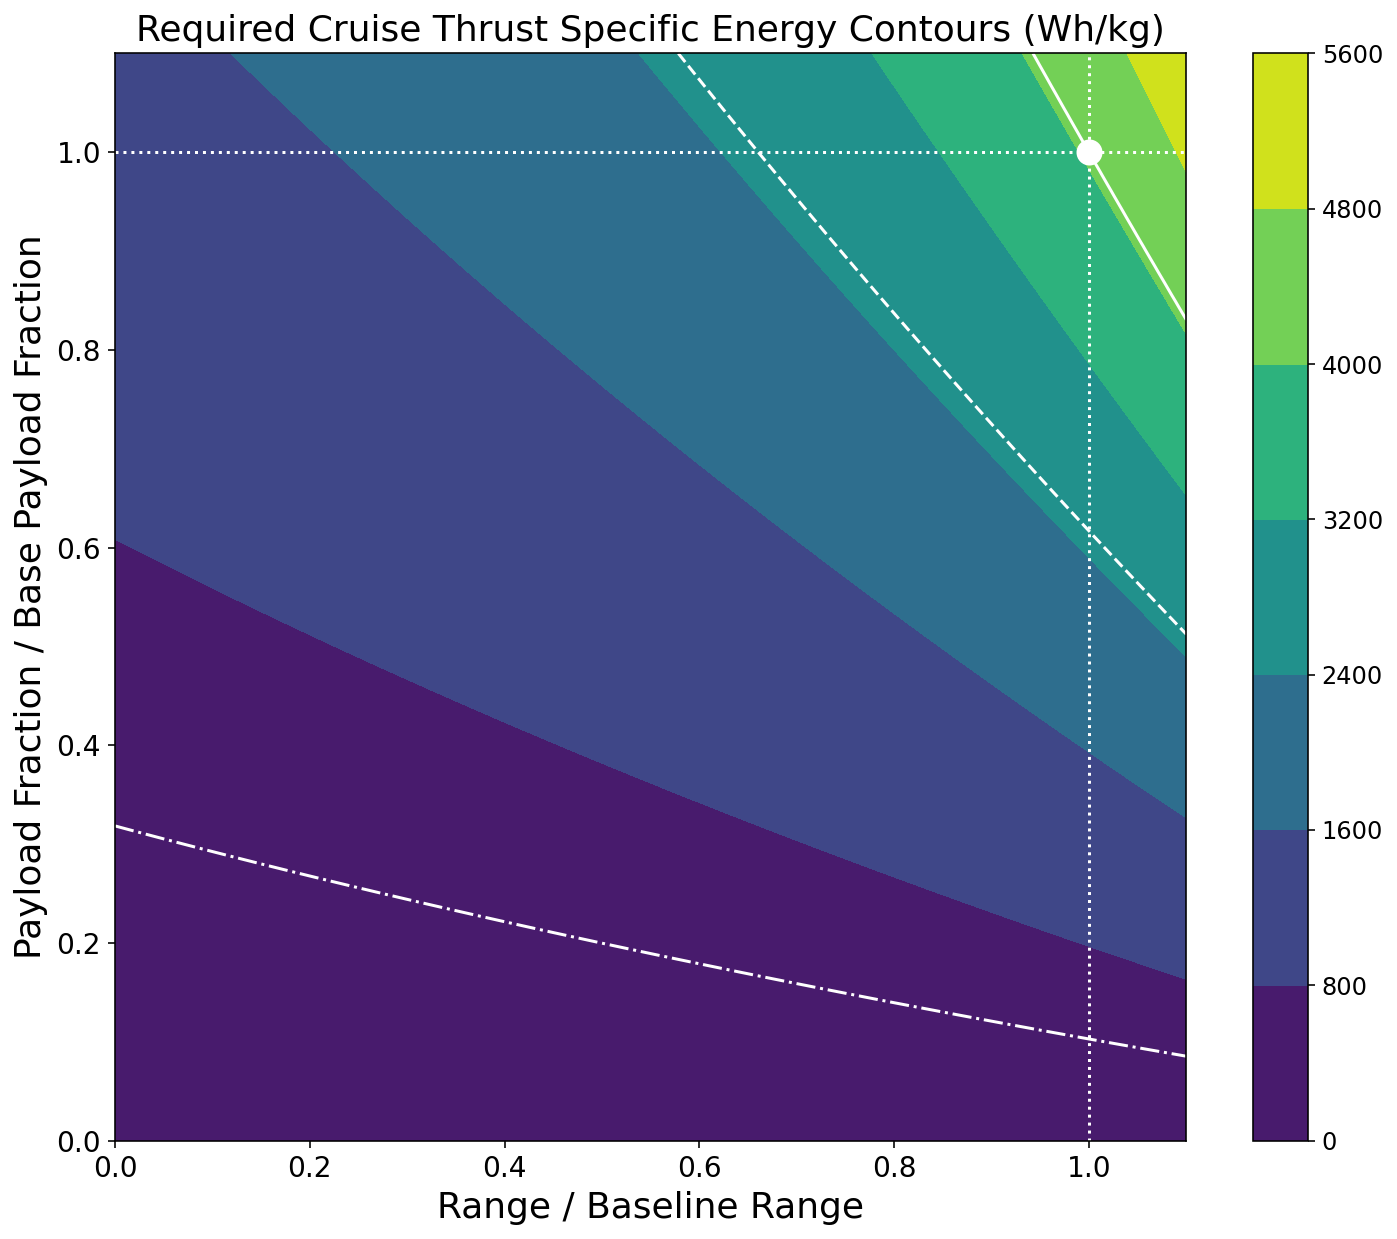

In [ ]:
# Thrust specific energy contour map

range_km = np.linspace(base['range_km']*0, base['range_km']*1.1, 100)
mu_payload = np.linspace(base['mu_payload']*0, base['mu_payload']*1.1, 100)

plt.figure(figsize=(12,10))
plt.contourf(range_km/base['range_km'], mu_payload/base['mu_payload'], 
             thrust_specific_energy_Wh_kg( range_km[:,None], mu_payload[None,:]))
cb = plt.colorbar()
cb.ax.tick_params(labelsize='large')

# Draw the contour for the current propulsion system
plt.contour(range_km/base['range_km'], mu_payload/base['mu_payload'], 
             thrust_specific_energy_Wh_kg( range_km[:,None], mu_payload[None,:]),[base['tse_Wh_kg']], colors=['white'])


# Draw the contour for the REEACH enabled propulsion system
plt.contour(range_km/base['range_km'], mu_payload/base['mu_payload'], 
             thrust_specific_energy_Wh_kg( range_km[:,None], mu_payload[None,:]),
            [elec_tse_Wh_kg(reeach)], colors=['white'], linestyles='--')

# Draw the contour for the REEACH enabled propulsion system
plt.contour(range_km/base['range_km'], mu_payload/base['mu_payload'], 
             thrust_specific_energy_Wh_kg( range_km[:,None], mu_payload[None,:]),
            [elec_tse_Wh_kg(battery)], colors=['white'], linestyles='-.')


plt.xlabel('Range / Baseline Range', fontsize=18)
plt.ylabel('Payload Fraction / Base Payload Fraction', fontsize=18)
plt.title('Required Cruise Thrust Specific Energy Contours (Wh/kg)', fontsize=18)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.axvline(x=1.0, color='white',linestyle=':')
plt.axhline(y=1.0, color='white',linestyle=':')
plt.plot([1.0], [1.0], 'wo', markersize=12)

plt.show()

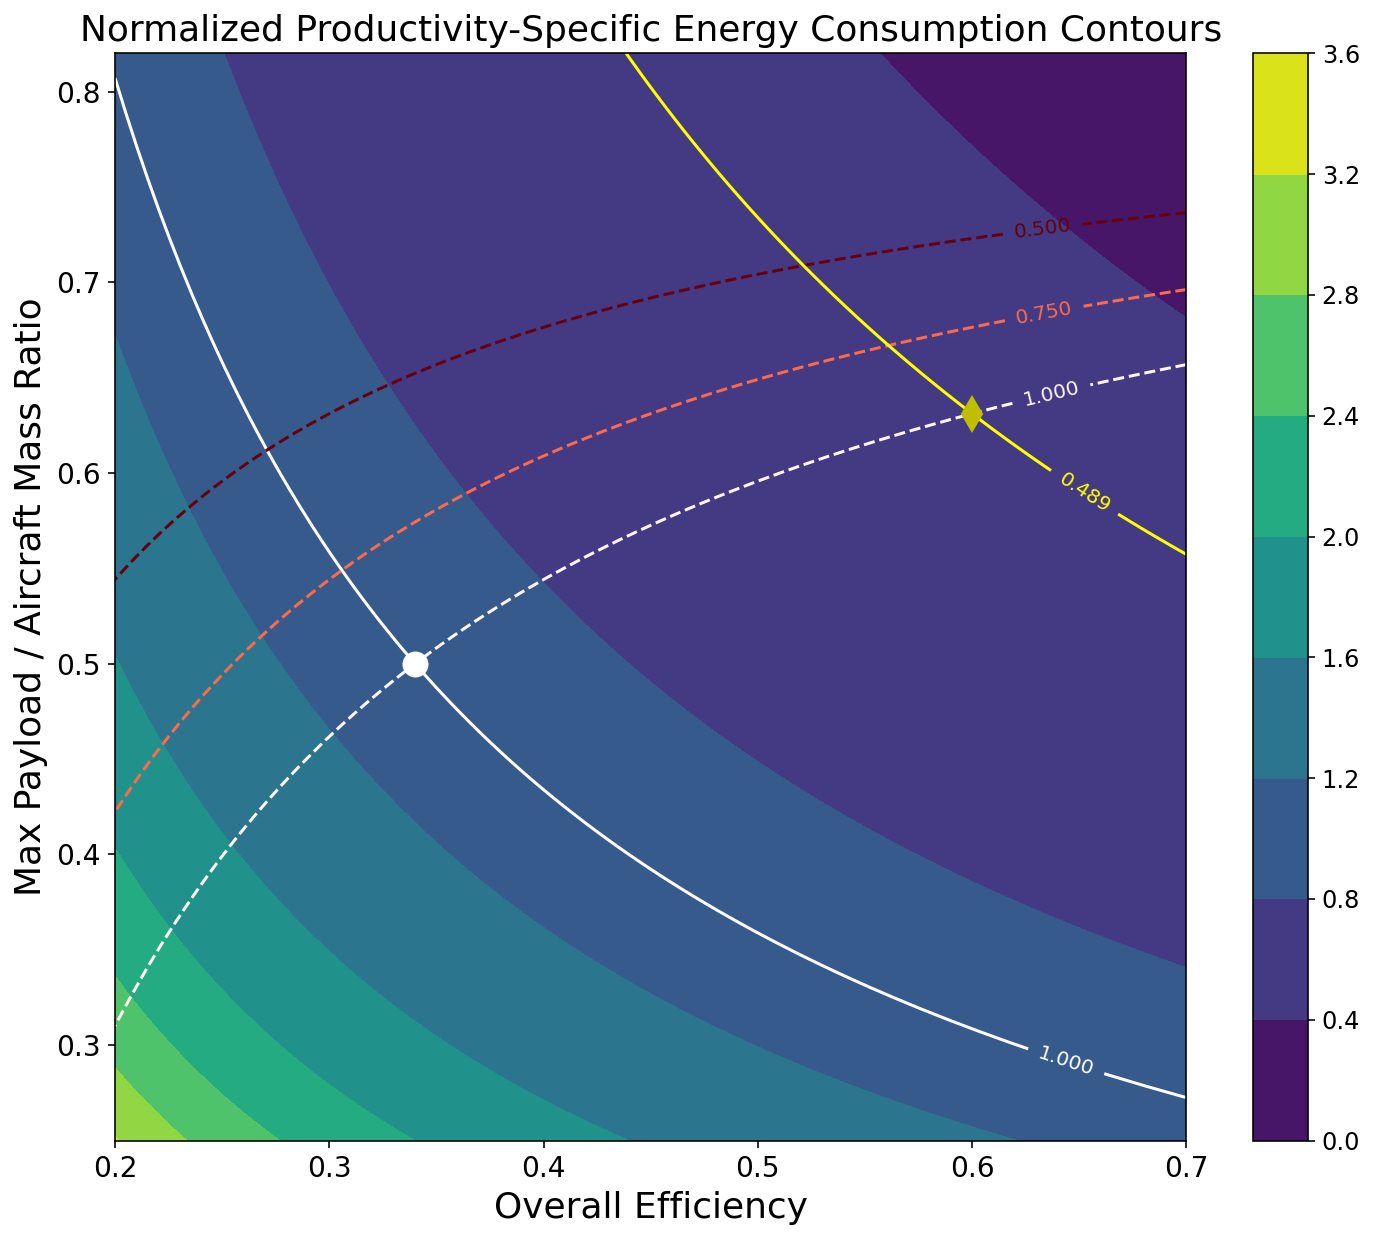

In [ ]:
# Productivity specific energy consumption

eta_0 = np.linspace(0.2, 0.7, 99)
mu_payload = np.linspace(0.25, base['mu_gtow']-1, 100)

fig, ax = plt.subplots(figsize=(12,10))
cs_tse = ax.contourf( eta_0, mu_payload, pse_Wh_kgm( eta_0[None,:], mu_payload[:,None]) / base['pse_Wh_kgm'])
cb = plt.colorbar(cs_tse)
cb.ax.tick_params(labelsize='large')

# Draw the contour for the current propulsion system
cs_tse_base = ax.contour(eta_0, mu_payload, 
                        pse_Wh_kgm( eta_0[None,:], mu_payload[:, None]) / base['pse_Wh_kgm'],
                        [1.0], colors=['white'])
ax.clabel(cs_tse_base)


# Plot the baseline range contour
cs_range = ax.contour(eta_0, mu_payload, 
                      calcRange_km(zeta_fuel(mu_payload[:,None]), base['L_D'], eta_0[None,:], 
                                  base['fuel_lhv_MJ_kg']) / base['range_km'], 
                      [0.5,0.75,1.0], cmap='Reds_r', linestyles='--')
ax.clabel(cs_range)

# Locate the intersection between the Range = 1 contour and a nominal REEACH efficiency target
reeach_efficiency = 0.6
def reeach_payload(mu_pay):
  return calcRange_km(zeta_fuel(mu_pay), base['L_D'], reeach_efficiency, 
                      base['fuel_lhv_MJ_kg']) / base['range_km'] - 1 

mu_payload_reeach = newton_krylov(reeach_payload, 0.5)
plt.plot([reeach_efficiency], [mu_payload_reeach], 'yd', markersize=12)

# Draw the pse contour for the REEACH system
cs_tse_reeach = ax.contour(eta_0, mu_payload, 
                        pse_Wh_kgm( eta_0[None,:], mu_payload[:, None]) / base['pse_Wh_kgm'],
                        [pse_Wh_kgm(reeach_efficiency, mu_payload_reeach) / base['pse_Wh_kgm']], colors=['yellow'])
ax.clabel(cs_tse_reeach)


plt.xlabel('Overall Efficiency', fontsize=18)
plt.ylabel('Max Payload / Aircraft Mass Ratio', fontsize=18)
plt.title('Normalized Productivity-Specific Energy Consumption Contours', fontsize=18)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
#plt.axvline(x=base['efficiency'], color='white',linestyle=':')
#plt.axhline(y=base['mu_payload'], color='white',linestyle=':')
plt.plot([base['efficiency']], [base['mu_payload']], 'wo', markersize=12)



plt.show()


## REEACH FOA Specific Energy Definition
The mass-specific energy metric used in the REEACH FOA is designed to encompass the impact of the needs of the entire mission profile on the mission-average specific energy of the propulsion system.

$$SE_{EPSG} = \frac{LHV_{fuel}\sum_{i} M^{fuel}_{i}\eta_{i}}{\sum_{i} M^{fuel}_{i} + M_{system}}$$

The numerator and denominator may both be divided by the total mission fuel burn to yield 

$$SE_{EPSG} = \frac{LHV_{fuel}\sum_{i} \nu^{fuel}_{i}\eta_{i}}{1 + \nu_{system}}$$

In the above expression,

$$\nu^{fuel}_{i}=\frac{M^{fuel}_{i}}{\sum_{j} M^{fuel}_{j}}$$

$$\nu^{system}=\frac{M_{system}}{\sum_{j} M^{fuel}_{j}}$$ 

The mass of the propulsion system, $M_{system}$ may be expressed as

$$M_{system}=\frac{\bar{P}_{system}}{\bar{\pi}_{system}}$$

$\bar{\pi}_{system}$ is the mission-average specific power.

\begin{aligned}
\nu_{system} & = \frac{\bar{P}_{system}}{\bar{\pi}_{system}\sum_{j} M^{fuel}_{j}} \\
& = \frac{\bar{\eta_{0}}LHV_{fuel}}{\bar{\pi}_{system}t_{mission}}
\end{aligned}

$P^{max}_{system}$ is the maximum power output of the system, and $SP_{system}$ is the mass-specific power of the system.



Mission average power fraction = 0.37802197802197796 



,Duration (hrs),Power Fraction,Efficiency,Fuel Fraction
Segment,,,,
Take Off,0.083333,1.00,0.35,0.029070
Climb 1,0.166667,0.70,0.35,0.040698
Climb 2,0.250000,0.50,0.35,0.043605
Climb 3,0.333333,0.35,0.35,0.040698
Cruise,5.000000,0.35,0.35,0.610465
Descent,0.500000,0.30,0.35,0.052326
Emer Take-Off,0.083333,1.00,0.35,0.029070
Emer Climb,0.166667,0.70,0.35,0.040698
Emer Cruise,0.500000,0.35,0.35,0.061047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


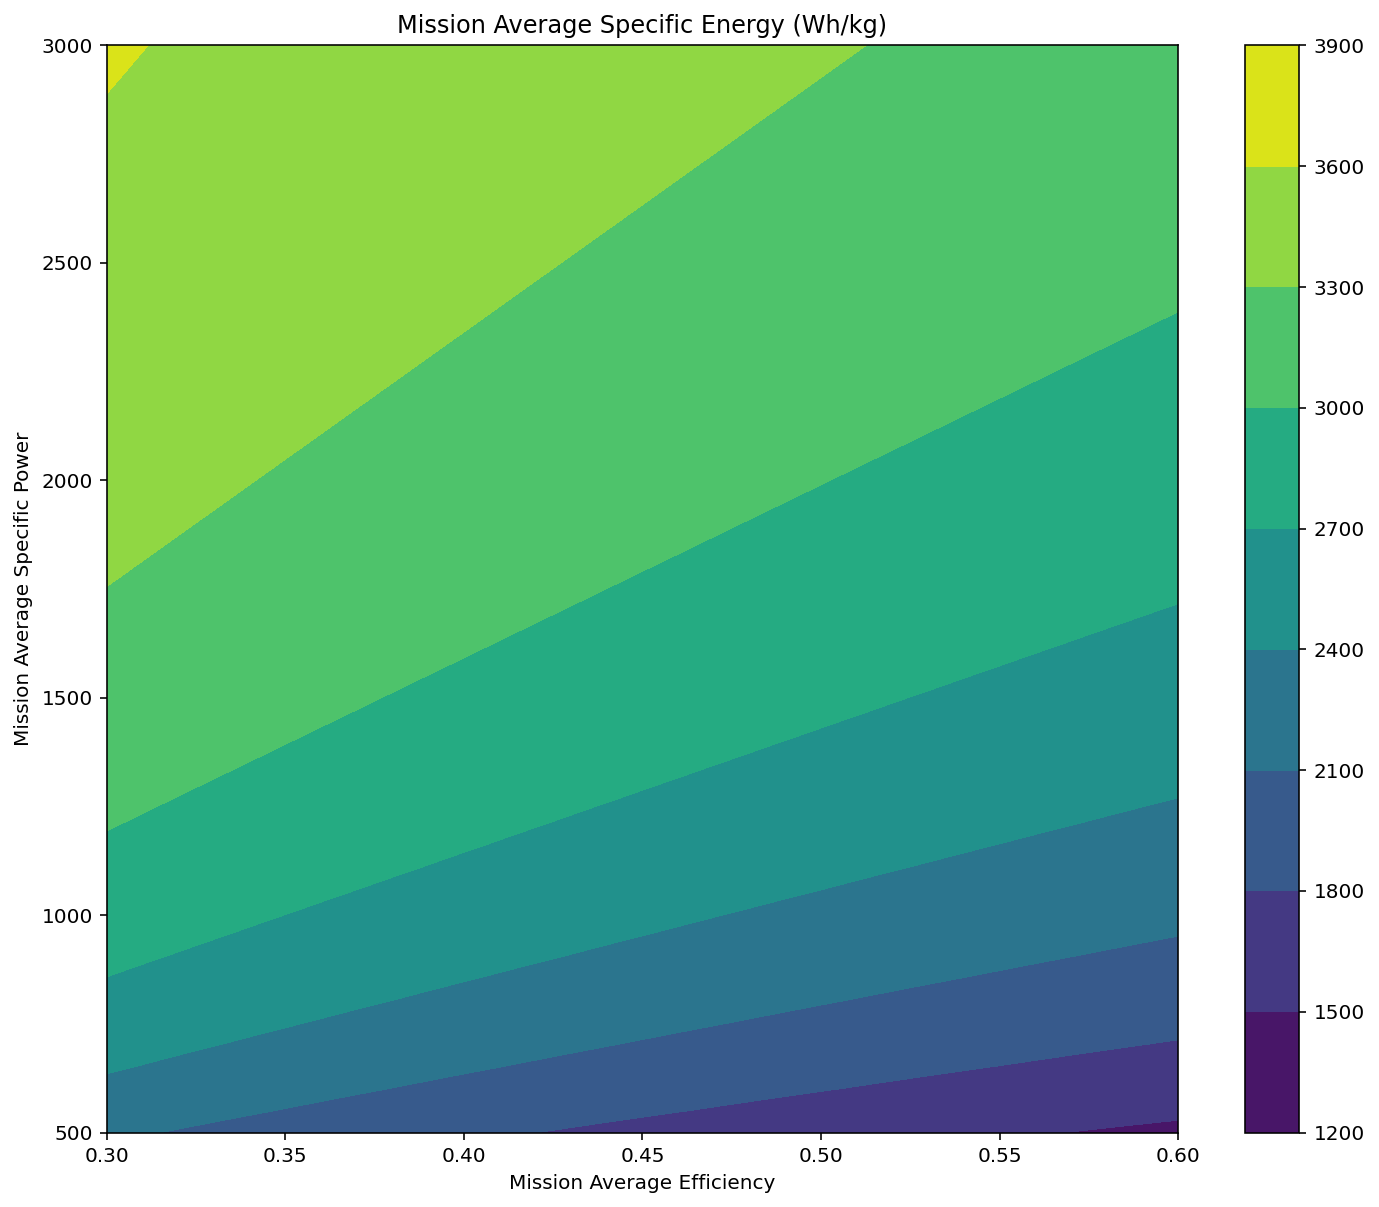

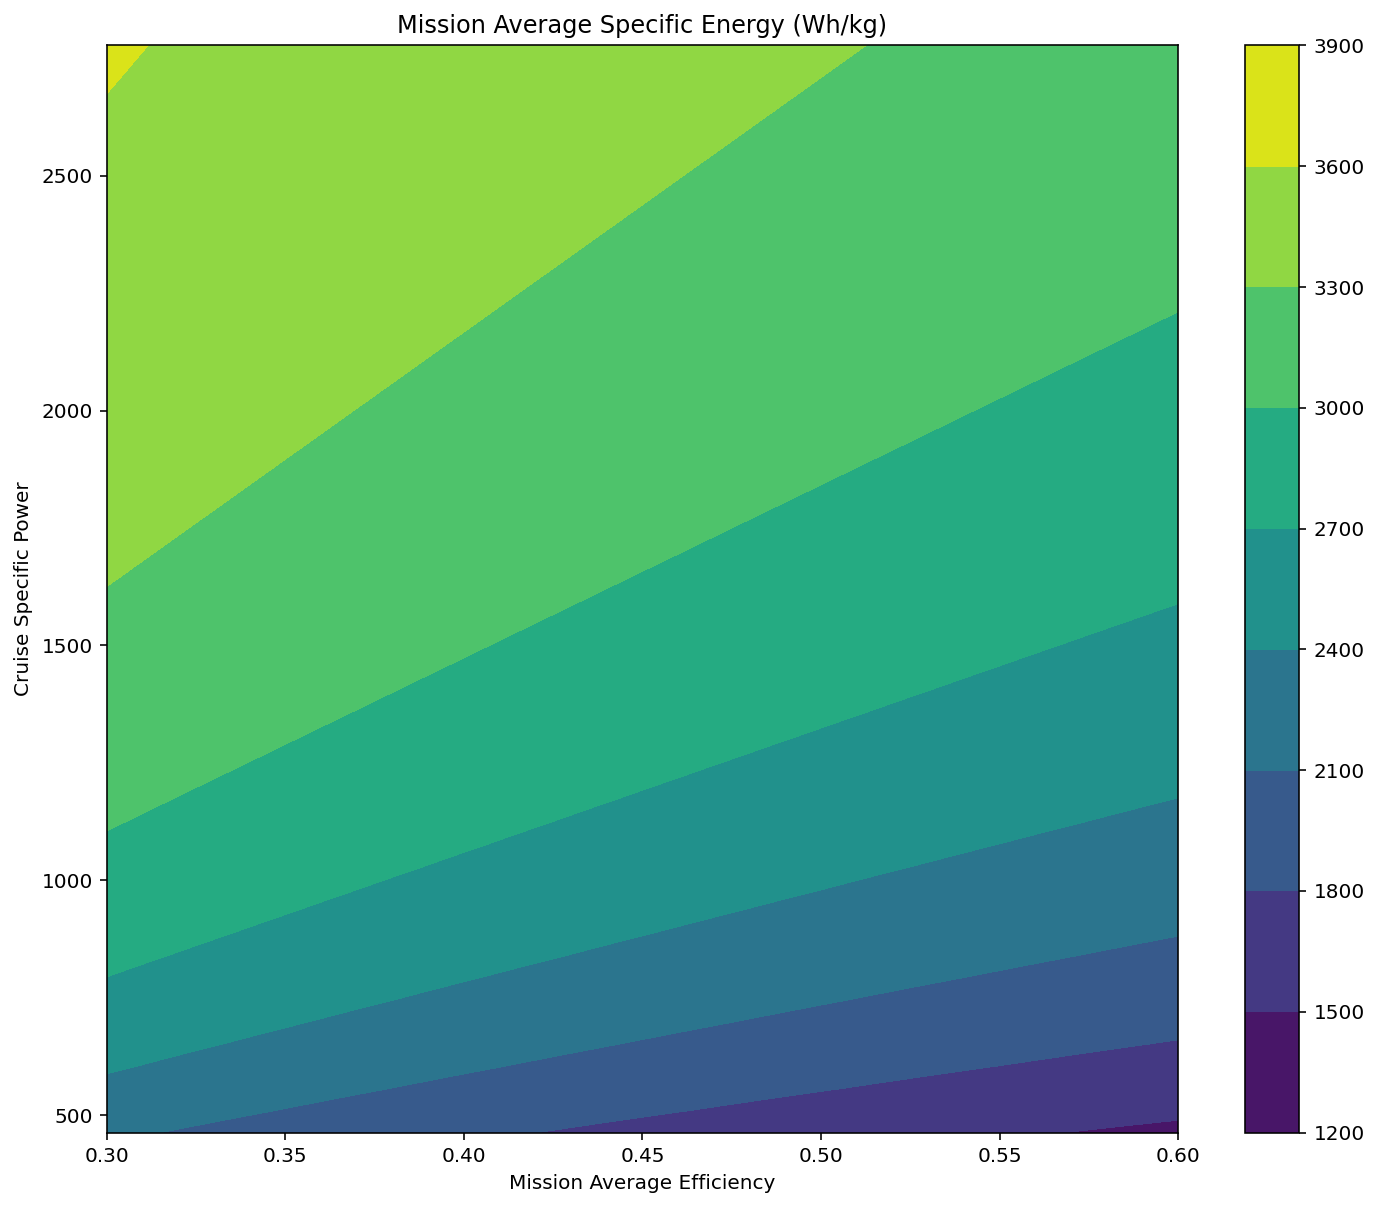

In [ ]:
"""REEACH FOA Mission Profile"""

def mission_specific_energy_Wh_kg(mission, avgSpecificPower_W_kg, avgEfficiency=None, lhv_fuel_MJ_kg=43.1):

  if type(mission['Fuel Fraction']) != type(pd.Series()):
    dotprod = mission['Fuel Fraction'] * mission['Efficiency']
  else:
    dotprod = mission['Fuel Fraction'].dot(mission['Efficiency'])

  # Mission average efficiency
  if avgEfficiency is None:
    avgEfficiency = dotprod

  # System to fuel mass ratio
  mu_system = avgEfficiency * lhv_fuel_MJ_kg * 1e6 / avgSpecificPower_W_kg / mission['Duration (hrs)'].sum() / 3600

  return lhv_fuel_MJ_kg / 3.6 * dotprod / ( 1 + mu_system ) * 1000
  
# Segment
segment = ['Take Off', 'Climb 1', 'Climb 2', 'Climb 3', 'Cruise', 'Descent' , 'Emer Take-Off', 'Emer Climb', 'Emer Cruise', 'Emer Descent']

# Mission segment duration
segDuration_hrs = [1.0/12.0, 1.0/6.0, 0.25, 1.0/3.0, 5.0, 0.5, 1.0/12.0, 1.0/6.0, 0.5, 0.5]

# Segment Power (fraction of max)
segPowerFrac = [1.0, 0.7, 0.5, 0.35, 0.35, 0.3, 1.0, 0.7, 0.35, 0.3]

# Mission average power fraction
avgPowerFrac = np.dot(segDuration_hrs, segPowerFrac) / np.sum(segDuration_hrs)
print(f'Mission average power fraction = {avgPowerFrac} \n')

# Efficiency
segEffic = 0.35*np.ones_like(segPowerFrac)

mission =  pd.DataFrame(data=np.array([segDuration_hrs, segPowerFrac, segEffic]).T , 
                        columns=['Duration (hrs)', 'Power Fraction', 'Efficiency'],
                        dtype=np.float32)

mission['Segment'] = segment
mission.set_index('Segment', inplace=True)

mission['Fuel Fraction'] = mission['Duration (hrs)'] * mission['Power Fraction'] / mission['Efficiency']
mission['Fuel Fraction'] = mission['Fuel Fraction']/mission['Fuel Fraction'].sum()

display(mission)

# Calculate the segment specific power given the mission average specific power
def segment_specific_power_W_kg(avg_specific_power_W_kg, segment):
  return avg_specific_power_W_kg * mission.loc[segment, 'Power Fraction'] / avgPowerFrac

# Evaluate sensitivity of mission specific energy to efficiency and the specific power
efficiency = np.linspace(0.3,0.6,75)
specific_power_W_kg = np.linspace(500,3000,50)

plt.figure(figsize=(12,10))
plt.contourf(efficiency, specific_power_W_kg, 
             mission_specific_energy_Wh_kg(mission, specific_power_W_kg[:,None], 
                                           efficiency[None,:]))
plt.xlabel('Mission Average Efficiency')
plt.ylabel('Mission Average Specific Power')
plt.title('Mission Average Specific Energy (Wh/kg)')
plt.colorbar()

plt.figure(figsize=(12,10))
plt.contourf(efficiency, segment_specific_power_W_kg(specific_power_W_kg, 'Cruise'), 
             mission_specific_energy_Wh_kg(mission, specific_power_W_kg[:,None], 
                                           efficiency[None,:]))
plt.xlabel('Mission Average Efficiency')
plt.ylabel('Cruise Specific Power')
plt.title('Mission Average Specific Energy (Wh/kg)')
plt.colorbar()

## Impact of variable propulsion system mass
As the mass of the propulsion system changes, the combined fuel and payload capacity of the aircraft will change as well *ceteris paribus*.

The combined fuel and payload capacity of an aircraft may be expressed as
$$\zeta_{payload} + \zeta_{fuel} = 1 - \zeta_{structure} - \zeta_{propulsion}$$

Assuming that the aircraft structure remains a constant fraction of the gross take of mass, the combined fuel and payload capacity for REEACH systems may be expressed as 

$$\zeta_{payload} + \zeta_{fuel} = 1 - \zeta_{structure} - \zeta_{propulsion}^{base}\frac{SP_{base}}{SP_{REEACH}}$$

The updated payload to aircraft (propulsion and structure) mass ratio may then be expressed as 
$$\mu_{payload} = \frac{\zeta_{payload}}{\zeta_{structure}+\zeta_{propulsion}^{base}\frac{SP_{base}}{SP_{REEACH}}}$$

$\zeta_{structure}$ may be calculated from $\zeta_{propulsion}$ and $\mu_{propulsion}$ as follows.

$$\zeta_{structure} = \frac{M_{structure}}{M_{gtow}}$$

$$\mu_{propulsion} = \frac{M_{propulsion}}{M_{structure}+M_{propulsion}}$$

$$M_{structure} = M_{propulsion}\left( \frac{1}{\mu_{propulsion}} - 1 \right)$$

$$\zeta_{structure} = \zeta_{propulsion}\left( \frac{1}{\mu_{propulsion}} - 1 \right)$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


Text(0.34400000000000003, 1569.7482014388488, 'Base')

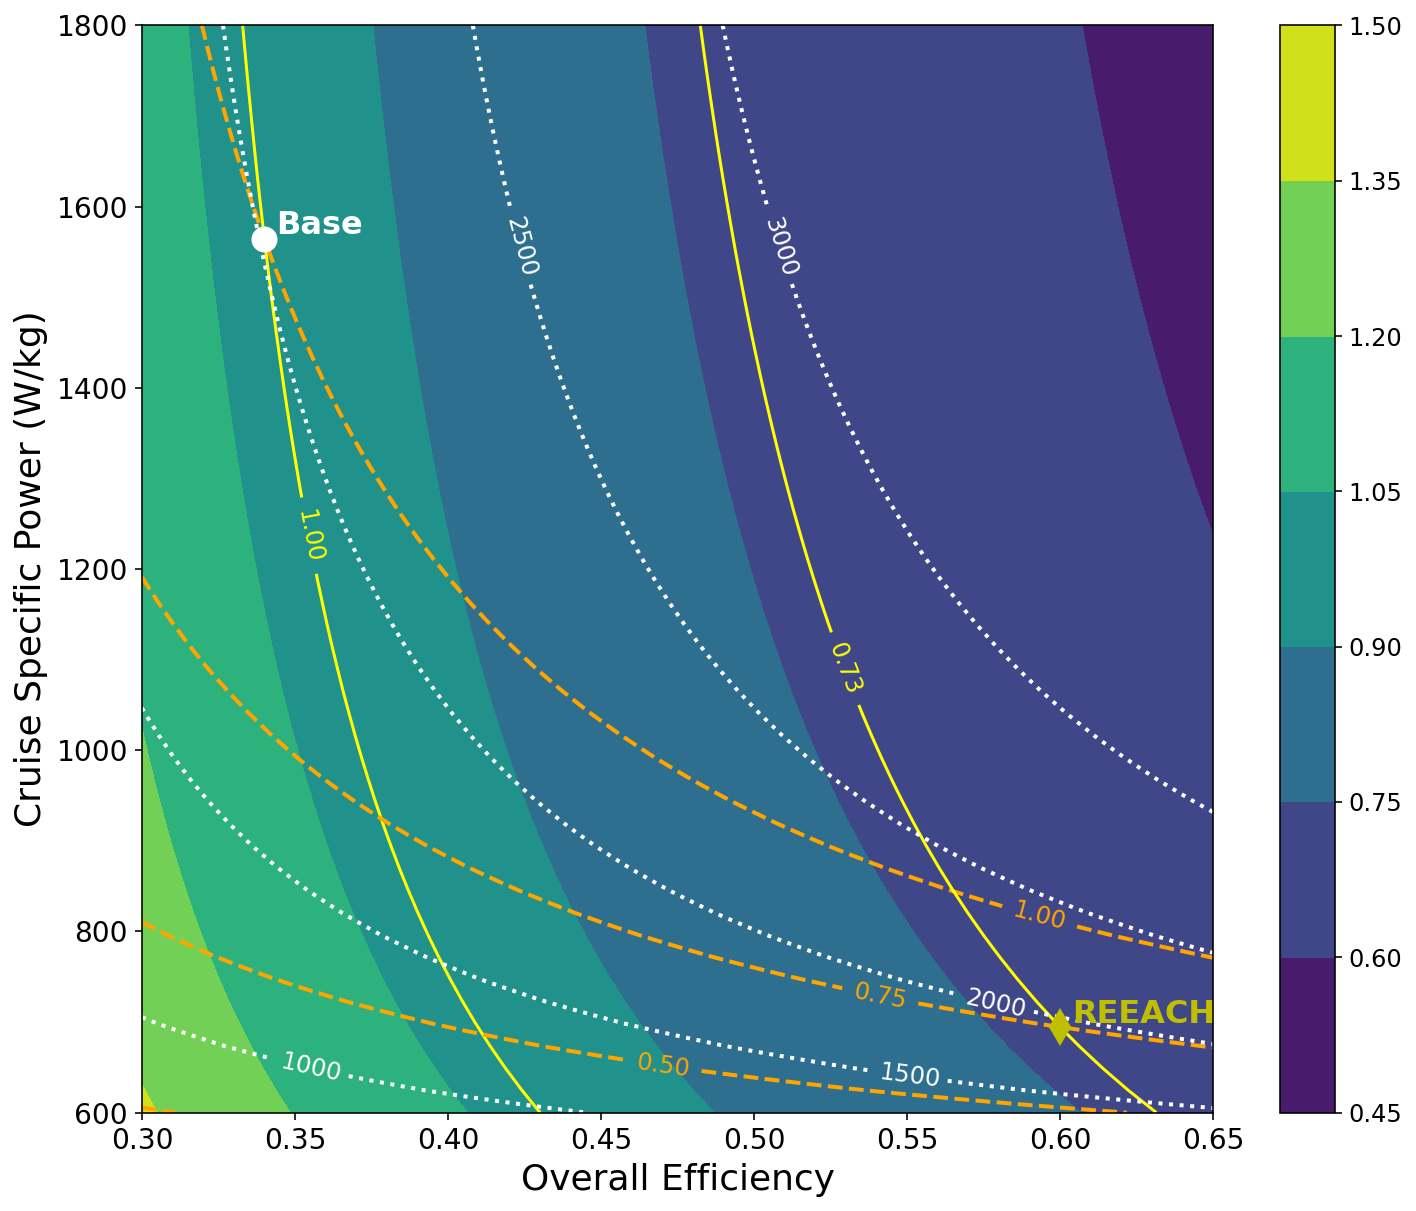

In [ ]:
"""Draw contours of productivity specific energy consumption, range & REEACH mission specific energy
versus cruise specific power & efficiency.

Keep the payload to gross take off mass ratio constant and vary the fuel mass
to keep the aircraft mass constant as the mass of the propulsion system changes."""

eta_0 = np.linspace(0.3,0.65,75)
specific_power_W_kg = np.linspace(600,1800,50)

# Calculate the propulsion to gross take-off mass ratio
def calc_zeta_propulsion(sp_W_kg):
  return base['zeta_propulsion']*base['SP_cruise_W_kg']/sp_W_kg

# Calculate mu_payload given the propulsion system specific power
def calc_mu_payload(sp_W_kg): 
  return base['zeta_payload'] / (base['zeta_structure'] + calc_zeta_propulsion(sp_W_kg))
  
# Calculate the fuel to gross take-off mass ratio
def calc_zeta_fuel(sp_W_kg):
  return 1 - base['zeta_payload'] - base['zeta_structure'] - calc_zeta_propulsion(sp_W_kg)

# Draw the productivity specific energy consumption contours
fig, ax = plt.subplots(figsize=(12,10))
cs_tse = ax.contourf( eta_0, specific_power_W_kg, pse_Wh_kgm( eta_0[None,:], 
                                                             calc_mu_payload(specific_power_W_kg[:,None])) / base['pse_Wh_kgm'],
                     )
cb = plt.colorbar(cs_tse)
cb.ax.tick_params(labelsize='large')

# Draw the contour for the current propulsion system
cs_tse_base = ax.contour(eta_0, specific_power_W_kg, 
                        pse_Wh_kgm( eta_0[None,:], calc_mu_payload(specific_power_W_kg[:,None])) / base['pse_Wh_kgm'],
                        [1.0], colors=['yellow'])
ax.clabel(cs_tse_base, fontsize=12, fmt="%.2f")

# Plot the baseline range contour
cs_range = ax.contour(eta_0, specific_power_W_kg, 
                      calcRange_km(calc_zeta_fuel(specific_power_W_kg[:,None]), base['L_D'], eta_0[None,:], 
                                  base['fuel_lhv_MJ_kg']) / base['range_km'], [0, 0.25,0.5,0.75,1.0], 
                      colors='orange', linestyles='--', linewidths=2)
ax.clabel(cs_range, fontsize=12, fmt="%.2f")

# Locate the intersection between the Range = 1 contour and anominal REEACH efficiency target
reeach_efficiency = 0.6; range_target = 0.75
def calc_reeach_payload(sp_W_kg):
  return calcRange_km(calc_zeta_fuel(sp_W_kg), base['L_D'], reeach_efficiency, 
                      base['fuel_lhv_MJ_kg']) / base['range_km'] - range_target 

sp_W_kg_reeach = newton_krylov(calc_reeach_payload, 1000)
plt.plot([reeach_efficiency], [sp_W_kg_reeach], 'yd', markersize=12)
plt.text(reeach_efficiency+0.004, sp_W_kg_reeach+5,'REEACH', fontsize=16, color="y", fontweight="bold")

# REEACH individual team cruise specific power and overall efficiency targets
reeach_targets = {'RTRC-CoPower': (669, 0.50, 'SAF'), 'GE': (755, 0.49, 'SAF'), 'ULL': (621, 0.57, 'SAF'), 'PCI': (674, 0.65, 'SAF')} #,
#                  'UMD': (741, 0.48, 'LNG'), 'TTU': (717, 0.49, 'LNG'), 'UCSD': (334, 0.51, 'LNG'), 
#                  'RTRC-ZapTurbo': (2501, 0.66, 'NH3')}

#ax.plot([x[1] for x in reeach_targets.values()], [y[0] for y in reeach_targets.values()], 'yo', markersize=10)

# Draw the pse contour for the REEACH system
cs_tse_reeach = ax.contour(eta_0, specific_power_W_kg, 
                        pse_Wh_kgm( eta_0[None,:], calc_mu_payload(specific_power_W_kg[:, None])) / base['pse_Wh_kgm'],
                        [pse_Wh_kgm(reeach_efficiency, calc_mu_payload(sp_W_kg_reeach)) / base['pse_Wh_kgm']], colors=['yellow'])
ax.clabel(cs_tse_reeach, fontsize=12, fmt="%.2f")

# Add mission specific energy contours
cruise = mission.loc['Cruise']; cruise_specific_energy_Wh_kg = np.zeros([len(specific_power_W_kg), len(eta_0)])
for i, eff in enumerate(eta_0):
  cruise['Efficiency'] = eff
  for j, sp_W_kg in enumerate(specific_power_W_kg):

    # Update the definition of the mission
    cruise['Duration (hrs)'] = calcRange_km(calc_zeta_fuel(sp_W_kg), base['L_D'], eff, 
                                            base['fuel_lhv_MJ_kg']) / base['cruise_speed_km_hr']
    # print(f'Duration = {cruise["Duration (hrs)"]}')

    # Calculate the mission specific energy
    cruise_specific_energy_Wh_kg[j,i] = mission_specific_energy_Wh_kg(cruise, sp_W_kg)


cs_mse_reeach = ax.contour(eta_0, specific_power_W_kg, cruise_specific_energy_Wh_kg, [0, 500, 1000, 1500, 2000, 2500, 3000],
                           colors="white", linestyles=':', linewidths=2)
ax.clabel(cs_mse_reeach, fontsize=12, fmt='%.0f')

plt.xlabel('Overall Efficiency', fontsize=18)
plt.ylabel('Cruise Specific Power (W/kg)', fontsize=18)
#plt.title('Normalized Productivity-Specific Energy Consumption Contours', fontsize=18)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
#plt.axvline(x=base['efficiency'], color='white',linestyle=':')
#plt.axhline(y=base['mu_payload'], color='white',linestyle=':')
plt.plot([base['efficiency']], [base['SP_cruise_W_kg']], 'wo', markersize=12)
plt.text(base['efficiency']+0.004, base['SP_cruise_W_kg']+5,'Base', fontsize=16, color="w", fontweight="bold")